In [1]:
import string

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 

In [2]:
from sklearn.metrics import accuracy_score

In [3]:
PATH = '/Users/lordzeeee/Library/Mobile Documents/com~apple~CloudDocs/PatternRec/files/Lab_5/'
df_emnist = pd.read_csv(PATH + "emnist-letters-train.csv", header = None)

In [4]:
def create_etalons(df_emnist, knumber, image_size = 28, space = False):
    """
    Create etalons from emnist dataset. Use latin symbols.

    Args:
        df_emnist ([type]): [description]
        knumber ([type]): number of latin symbols to use for
        image_size (int, optional): [description]. Defaults to 28.
        space (bool, optional): If True ' ' will be used id dataset(for some prettiness). Also may impact on accuracy of prediction. Defaults to False.
    """
    emnist_samples = df_emnist.sample(1000).drop_duplicates(0).sort_values(0)[:knumber]
    etalons_dict = {index : item[1:].reshape(image_size, image_size).T.astype('float32') for index, item in enumerate(emnist_samples.values)}
    etalons_strings = {list(string.ascii_uppercase)[item - 1] : index for index, item in enumerate(emnist_samples.values[:, 0])}
    etalons_strings_inverse = {index : list(string.ascii_uppercase)[item - 1]for index, item in enumerate(emnist_samples.values[:, 0])}
    if space:
        space = np.zeros([image_size, image_size])
        etalons_dict[knumber] = space
        etalons_strings_inverse[knumber] = ' '
        etalons_strings[' '] = knumber
    plt.imshow(emnist_samples.iloc[:knumber, 1:].values.reshape(image_size * knumber, image_size).T) # without space
    print(etalons_strings)
    return etalons_dict, etalons_strings, etalons_strings_inverse

In [5]:
def image_stack(list_images):
    """Stack images horizontaly

    Args:
        list_images (list): Images to stack

    Returns:
        np.array: Result Array
    """
    return np.hstack(list_images)
    
def string_convert(text_str, etalons_dict, etalons_strings):
    input_text = list(text_str.upper())
    return image_stack([etalons_dict[etalons_strings[character]] for character in input_text if character in etalons_strings.keys()])

def get_noisy(image, mu, sigma): 
    row, col = image.shape
    gauss = np.random.normal(mu, sigma,(row, col))
    gauss = gauss.reshape(row, col)
    noisy = image + gauss
    return noisy % 255

In [6]:
def read_sample_text(path, etalons):
    """Read text from file. Use only etalon symbols .

    Args:
        path ([type]): [description]
        etalons ([type]): [description]

    Raises:
        Exception:

    Returns:
        [type]: [description]
    """
    with open(path, 'r') as file:
        text = ''.join([i for i in list(' '.join(file.readlines()).upper()) if i in etalons.keys()])
        diff = set(text).difference(etalons.keys())
        if len(diff) > 0:
            raise Exception(f"Next characters are missing or excess - {diff} .")
        else: return text


def prepare_dataset(sample_text, etalons_dict, etalons_strings, mu = 0, sigma = 10, nsamples = 110, chunk_size = 50, sample_size = 100):
    """[summary]

    Args:
        sample_text ([type]): Text from file    
        etalons_dict ([dict]): Etalons {index: etalon image}
        etalons_strings ([dict]): {Etalon symbol: Etalon index}
        mu (int, optional): [description]. Defaults to 0.
        sigma (int, optional): [description]. Defaults to 10.
        nsamples (int, optional): [description]. Defaults to 110.
        chunk_size (int, optional): [description]. Defaults to 50.
        sample_size (int, optional): [description]. Defaults to 100.

    Returns:
        [type]: [description]
    """
    # test_dataset = []
    # train_dataset = [] 
    # for i in range(nsamples):
    #     y_idx = np.random.randint(0, len(sample_text), sample_size)
    #     y_values = ''.join([sample_text[index] for index in y_idx])
    #     x_values = string_convert(y_values, etalons_dict, etalons_strings)
    #     x_noised = get_noisy(x_values, mu = mu, sigma = sigma)
    #     test_dataset.append([y_values, x_noised]) if i < 100 else train_dataset.append([y_values, x_noised])
    chunks = [sample_text[i:i + chunk_size] for i in range(0, len(sample_text), chunk_size)][:-1]
    nchunks = len(chunks)
    test_dataset = []
    train_dataset = [] 
    for i in range(nsamples - 10):
        y_idx = np.random.choice(nchunks, int(sample_size / chunk_size))
        y_values = ''.join([chunks[index] for index in y_idx])
        x_values = string_convert(y_values, etalons_dict, etalons_strings)
        x_noised = get_noisy(x_values, mu = mu, sigma = sigma)
        test_dataset.append([y_values, x_noised])
    chunk_size = 100
    chunks = [sample_text[i:i + chunk_size] for i in range(0, len(sample_text), chunk_size)][:-1]
    # print(chunks)
    for j in range(10):
        y_train_values = ''.join(chunks[j])
        x_train_values = string_convert(y_train_values, etalons_dict, etalons_strings)
        x_noised_values = get_noisy(x_train_values, mu = mu, sigma = sigma)
        train_dataset.append([y_train_values, x_noised_values])

    return train_dataset, test_dataset

In [7]:
def transform(X):
    return np.ravel(X)

def fit(train_df, etalons, image_size, text_size):
    """Fit Perceptron for Fisher task

    Args:
        train_df (list): Train images and labels
        etalons (dict): Etalons {symbol : index }
        image_size (int): W
        text_size ([type]): Symbols in one image

    Returns:
        [type]: [description]
    """
    K_ = len(etalons.keys())
    alpha = np.zeros((image_size, K_ * image_size), dtype='float64')
    corrections = 1
    while (corrections > 0):
        corrections = 0
        for index, item in enumerate(train_df):
            labels, x_train = item[0], item[1]
            for _i in range(text_size):
                real_label = etalons[labels[_i]]
                X_item = x_train[:, _i * image_size : (_i + 1) * image_size]
                current_x = transform(X_item)
                for k_j in etalons.values():
                    if k_j == real_label:
                        continue
                    alpha_raw = alpha[:, real_label * image_size : (real_label + 1) * image_size]
                    alpha_current = transform(alpha_raw)
                    value_ = np.dot(alpha_current, current_x)
                    alpha_j_raw = alpha[:, k_j * image_size : (k_j + 1) * image_size]
                    alpha_j = transform(alpha_j_raw)
                    value_j = np.dot(alpha_j, current_x)
                    if value_ <= value_j:
                        corrections += 1
                        alpha[:, real_label * image_size: (real_label + 1) * image_size] += X_item
                        alpha[:, k_j * image_size : (k_j + 1) * image_size] -= X_item
        # print(corrections)
    return alpha

def predict(test_df, alpha, etalons, image_size, text_size):
    """Predict output for test images

    Args:
        test_df (list): Test
        alpha ([type]): Alpha array
        etalons (dict): {symbol : index}
        image_size (int]): W
        text_size (int): Symbols in image 

    Returns:
        [type]: [description]
    """
    results = []
    for item in test_df:
        label, x_test = item[0], item[1]
        predicted_label = []
        for _i in range(text_size):
                X_item = x_test[:, _i * image_size : (_i + 1) * image_size]
                current_x = transform(X_item)
                values = np.zeros(len(etalons.keys()))
                for k in etalons.keys():
                    alpha_raw = alpha[:,  etalons[k] * image_size : (etalons[k] + 1) * image_size]
                    alpha_current = transform(alpha_raw)
                    values[etalons[k]] = np.dot(alpha_current, current_x)
                predicted_label.append(np.argmax(values))
        results.append((pd.concat([pd.Series(list(label)),pd.Series(predicted_label).astype(int)], axis = 1)))
    return results

def plot_results(test_df, predicted, _inverse_dict, etalons_dict, etalons_strings, image_size = 28, text_size = 100):
    """Return  image for predicted outputs

    Args:
        test_df (list): Test dataset with corrupted data
        predicted (list): Predicted labels
        _inverse_dict (dict): Inverse dict {index : symbol} for image generation
        etalons_dict (dict): {index : image}
        etalons_strings ([dict]): {symbol : image}
        image_size (int, optional): W. Defaults to 28.
        text_size (int, optional): Symbols in image. Defaults to 100.

    Returns:
        [type]: [description]
    """
    predicted_ = predicted[1].apply(lambda x : _inverse_dict[x])
    result = np.zeros((image_size,image_size * text_size))
    for i in range(len(test_df)):
        corrupted_image = test_df[i][1]
        clear_predicted = string_convert(''.join(predicted_[i* text_size:(i+1) * text_size]), etalons_dict, etalons_strings)
        result = np.vstack([result, np.vstack([corrupted_image, clear_predicted])])
    return result

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, ' ': 26}


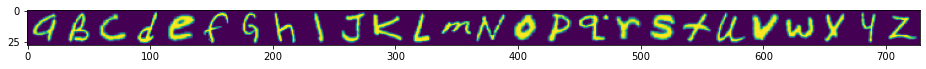

In [8]:
plt.figure(figsize = (16, 9))
K_ = 26 # Number of symbols to use
image_size = 28
text_len = 100
use_space = True
etalons_dict, etalons_strings, etalons_strings_inv = create_etalons(df_emnist, K_, image_size, use_space)
input_text = read_sample_text(PATH + '/dada_text.txt', etalons_strings)

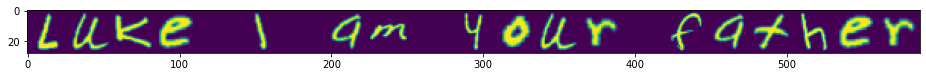

In [9]:
plt.figure(figsize = (16, 9))
test = "Luke I am your Father"
test_image = string_convert(test, etalons_dict, etalons_strings)
plt.imshow(test_image)

In [10]:
train_df, test_df = prepare_dataset(input_text, etalons_dict, etalons_strings, mu = 1,  sigma = 20)
alpha_ = fit(train_df, etalons_strings, image_size, text_len)

In [11]:
print(len(train_df))
print(len(test_df))

10
100


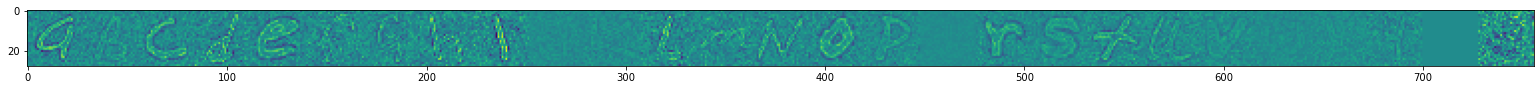

In [12]:
#alpha_images
plt.figure(figsize = (27, 9))
plt.imshow(alpha_)

In [13]:
plt.imsave(PATH + '/alpha.jpg', alpha_)

In [14]:
predicted = pd.concat(predict(test_df, alpha_, etalons_strings, image_size, text_len))
acc = accuracy_score(predicted[1], predicted[0].apply(lambda x : etalons_strings[x]))
print(f'Accuracy - {acc}')

Accuracy - 0.7951


In [15]:
result = plot_results(test_df, predicted, etalons_strings_inv, etalons_dict, etalons_strings)
plt.imsave(PATH + '/result.jpg', result)